### Load Data:

In [1]:
import pandas as pd

df = pd.read_csv('data/laurence.txt', sep="/n", header=None, engine='python')
df.columns = ["text"]
df["text"] = df["text"].apply(lambda x: x.lower())
df.head()

,text
0,come all ye maidens young and fair
1,and you that are blooming in your prime
2,always beware and keep your garden fair
3,let no man steal away your thyme
4,for thyme it is a precious thing


### Tokenize & WordCloud:

2022-06-15 13:38:47.030164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


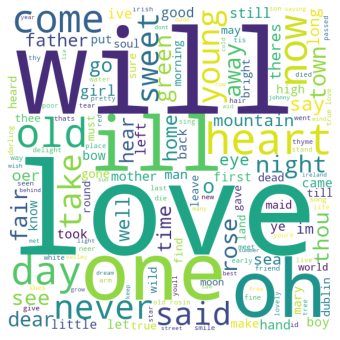

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from data.utils import word_cloud

corpus = df["text"].values.tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

word_cloud(" ".join(corpus))

### Pad sequences:

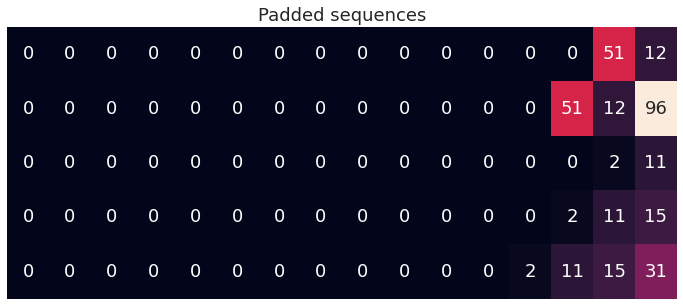

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from data.utils import one_hot

input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)
        
max_sequence_len = max([len(i) for i in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre"))
show = [i for i in input_sequences if max(i) < 100]
one_hot(show[:5], "Padded sequences", (12, 5))

### Create predictors and labels:

In [4]:
import tensorflow as tf

xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

word2num = tokenizer.word_index
num2word = {v: k for k, v in word2num.items()}

**Note:** Example label for number 10 

### Define Model:

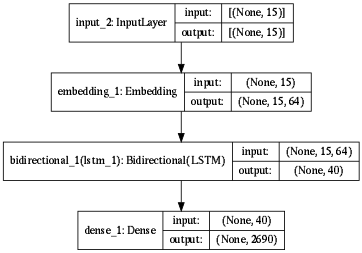

In [7]:
i = tf.keras.layers.Input(shape=(max_sequence_len-1, ))
x = tf.keras.layers.Embedding(total_words, 64)(i)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20))(x) 
o = tf.keras.layers.Dense(total_words, "softmax")(x)

model = tf.keras.Model(i, o)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

2022-06-15 13:39:03.370824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 129528880 exceeds 10% of free system memory.
2022-06-15 13:39:03.499614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-15 13:39:03.500139: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2294510000 Hz


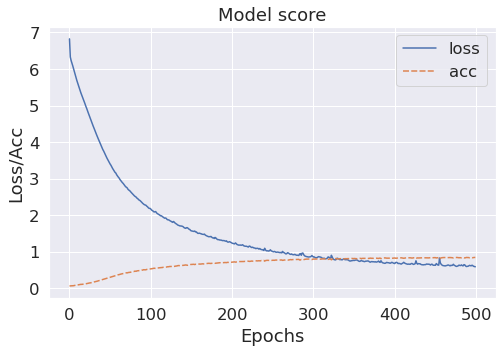

In [6]:
from data.utils import MyCallback

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)
 
history = model.fit(
    xs,
    ys,
    epochs=500,
    callbacks=[MyCallback()],
    verbose=0
)

### Load model:

In [8]:
import tensorflow as tf

model = tf.keras.models.load_model("data/model.h5")

### Model predict:

In [9]:
from IPython.display import display_html
from data.utils import to_html

seed_text = "Come all ye maidens young and fair"
next_words = 100

for i in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted: 
            output_word = word
            break
    seed_text += f" {output_word}"
    if i % 8 == 0:
        seed_text += "\n"

display_html(to_html(seed_text), raw=True)

Come all ye maidens young and fair and
 green and the fortune faith to see no
 oflynn boy please would painful jenny for kinds
 shes roses derry sea havent dead divils shall
 returnd truth red wind divils army for pure
 sea we farrell dublin well all weary young
 never no away to me farewell hoping on
 dawning but in lad and fled used to
 smother ghosts have again with me hand in
 me wherein runctions irishmen someone plain wid how
 write in slime clouded the land ill not
 had derry held sing great rest take truth
 beautiful shure whereon souls fell bid stars chanced
 bed danny wind

### Save model:

In [10]:
model.save("data/model.h5")